## QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

---

## Requirements

1. Scrape and prepare your own data.

2. **Create and compare at least two models for each section**. One of the two models should be a decision tree or ensemble model. The other can be a classifier or regression of your choosing (e.g. Ridge, logistic regression, KNN, SVM, etc).
   - Section 1: Job Salary Trends
   - Section 2: Job Category Factors

3. Prepare a polished Jupyter Notebook with your analysis for a peer audience of data scientists. 
   - Make sure to clearly describe and label each section.
   - Comment on your code so that others could, in theory, replicate your work.

4. A brief writeup in an executive summary, written for a non-technical audience.
   - Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

#### BONUS

5. Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions.

6. Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

---

In [1]:
# Data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# Plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

# Make sure charts appear in the notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Stats/regressions packages
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, roc_curve, auc, classification_report
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# NLP packages
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn import naive_bayes

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Enable viewing of all columns for DataFrames
pd.set_option('display.max_columns', None)

<div class="alert alert-warning">
    
We are reloading the original scraped data as we are now focusing on 'Title' instead of 'Salary'.

This is to ensure that we do not remove unnecessary rows as we did in Part 1. In Part 1 we dropped a lot of rows due to Null values and these values could potentially be needed in terms of modelling for Salary. For Part 2, we are focusing on Data Scientist and other data related jobs. Thus, we are mainly focusing on the 'Title' and 'Summary'/'Requirements' columns.

</div>

In [2]:
df = pd.read_csv('webdata.csv')

In [3]:
print(df.shape)
df.head()

(2775, 11)


,Unnamed: 0,Title,Company,Location,Salary from,Salary to,Salary Type,Employment Type,Seniority,Summary,Requirements
0,0,Business Analyst (AGILE),KELLY SERVICES (SINGAPORE) PTE. LTD.,"ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960","$4,000","$6,000",Monthly,Contract,Professional,Delivery experience in Agile is a must as new...,Requirements Requirements: Acted as a Scru...
1,1,Business Analyst (AGILE),KELLY SERVICES (SINGAPORE) PTE. LTD.,"ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960","$6,000","$9,000",Monthly,Contract,Professional,Delivery experience in Agile is a must as new...,Requirements Requirements: Acted as a Scru...
2,2,Business Analyst (AGILE),KELLY SERVICES (SINGAPORE) PTE. LTD.,"ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960","$9,000","$13,500",Monthly,Contract,Professional,Delivery experience in Agile is a must as new...,Requirements Requirements: Acted as a Scrum ...
3,3,Business Analyst,ACRONIS ASIA RESEARCH AND DEVELOPMENT PTE. LTD.,"SUNTEC TOWER THREE, 8 TEMASEK BOULEVARD 038988","$5,000","$7,000",Monthly,Full Time,Executive,"As a Business Analyst, you will be responsible...",Requirements 3+ years of experience in a busin...
4,4,IT Business Analyst - Regulatory Reporting,OPTIMUM SOLUTIONS (SINGAPORE) PTE LTD,"PLAZA 8 @ CBP, 1 CHANGI BUSINESS PARK CRESCENT...","$5,500","$8,000",Monthly,Full Time,Fresh/entry level,Optimum Solutions (Company Registration Number...,RequirementsJob Description: Functional expe...


In [4]:
df.isnull().sum()

Unnamed: 0           0
Title               67
Company             67
Location            67
Salary from        305
Salary to          305
Salary Type        304
Employment Type     67
Seniority          152
Summary             67
Requirements       258
dtype: int64

In [5]:
# Dropping the Unnamed: 0 column, rows where Title is null and duplicates
df.drop(columns='Unnamed: 0', inplace=True)
df = df[df['Title'].notnull()]
df.drop_duplicates(keep='first', inplace=True)
df.shape

(1606, 10)

In [6]:
# Cleaning up the Requirements column as it seems that they all start with 'requirements'
# Converting Title, Summary & Requirements to lowercase and creating a new column
# which combines the Summary and Requirements columns

cols = ['Title', 'Summary', 'Requirements']

for col in cols:
    df[col] = df[col].apply(lambda x: x.lower() if pd.notnull(x) else '')

df['Requirements'] = df['Requirements'].apply(lambda x: x[len('requirements'):] if x.startswith('requirements') else x)
df['Job Details'] = df['Summary'] + ' ' + df['Requirements']

In [7]:
def datacheck(string):
    '''
    Function to check if role is a data scientist, data science role, data role, analyst role or other
    Returns a category
    '''
    if 'data scientist' in string:
        return 'data science'
    elif 'data science' in string:
        return 'data science'
    elif 'data' in string:
        return 'data role'
    elif 'analyst' in string:
        return 'analyst role'
    else:
        return 'other'

In [8]:
# Identifying Data Scientist roles vs other data roles vs other jobs

df['Role Cat'] = df['Title'].apply(lambda x: datacheck(x))

In [9]:
# Subsetting the dataset to just 'data science', 'data' and 'analyst' job categories
df_cat = df[df['Role Cat'] != 'other'][['Role Cat', 'Job Details']]
df_cat.head()

,Role Cat,Job Details
0,analyst role,delivery experience in agile is a must as new...
1,analyst role,delivery experience in agile is a must as new...
2,analyst role,delivery experience in agile is a must as new...
3,analyst role,"as a business analyst, you will be responsible..."
4,analyst role,optimum solutions (company registration number...


In [10]:
# Setting up the Target variable for classification, 1 = 'data science' role, 0 = all other 'data' or 'analyst' roles
df_cat['Data Science'] = df_cat['Role Cat'].apply(lambda x: 1 if x=='data science' else 0)
df_cat.head()

,Role Cat,Job Details,Data Science
0,analyst role,delivery experience in agile is a must as new...,0
1,analyst role,delivery experience in agile is a must as new...,0
2,analyst role,delivery experience in agile is a must as new...,0
3,analyst role,"as a business analyst, you will be responsible...",0
4,analyst role,optimum solutions (company registration number...,0


In [11]:
df_cat['Data Science'].value_counts()

0    582
1    112
Name: Data Science, dtype: int64

In [12]:
y = df_cat['Data Science']
X = df_cat['Job Details']

In [13]:
# Creating a feature set from the Job Details using CountVectorizer
cvec = CountVectorizer(strip_accents = 'ascii')
Xcv = cvec.fit_transform(X)
print(Xcv.shape)
Xcv = pd.DataFrame(Xcv.todense(), columns=cvec.get_feature_names())

(694, 8136)


In [14]:
# Applying train-test split with stratify to ensure that the proportion of y is kept
X_train, X_test, y_train, y_test = train_test_split(Xcv, y, test_size=0.2, random_state=42, stratify=y)

# Checking baseline accuracy
baseline = 1 - np.mean(y_train)
print("Baseline:", baseline)

Baseline: 0.8378378378378378


In [15]:
# Applying Random Forest Classifier using GridSearchCV to find optimum parameters

ranf_parameters = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [None,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, verbose=1, cv=5)
ranf_result = ranf_gridsearcher.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  4.9min finished


In [16]:
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(X_test, y_test))
print('Baseline:', baseline)
confusion_matrix(y_test, ranfbest.predict(X_test))

Best mean cross-validated score achieved: 0.9207207207207208
Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Random Forest Classification score: 0.9136690647482014
Baseline: 0.8378378378378378


array([[116,   1],
       [ 11,  11]])

In [17]:
print(classification_report(y_test, ranfbest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       117
           1       0.92      0.50      0.65        22

   micro avg       0.91      0.91      0.91       139
   macro avg       0.92      0.75      0.80       139
weighted avg       0.91      0.91      0.90       139



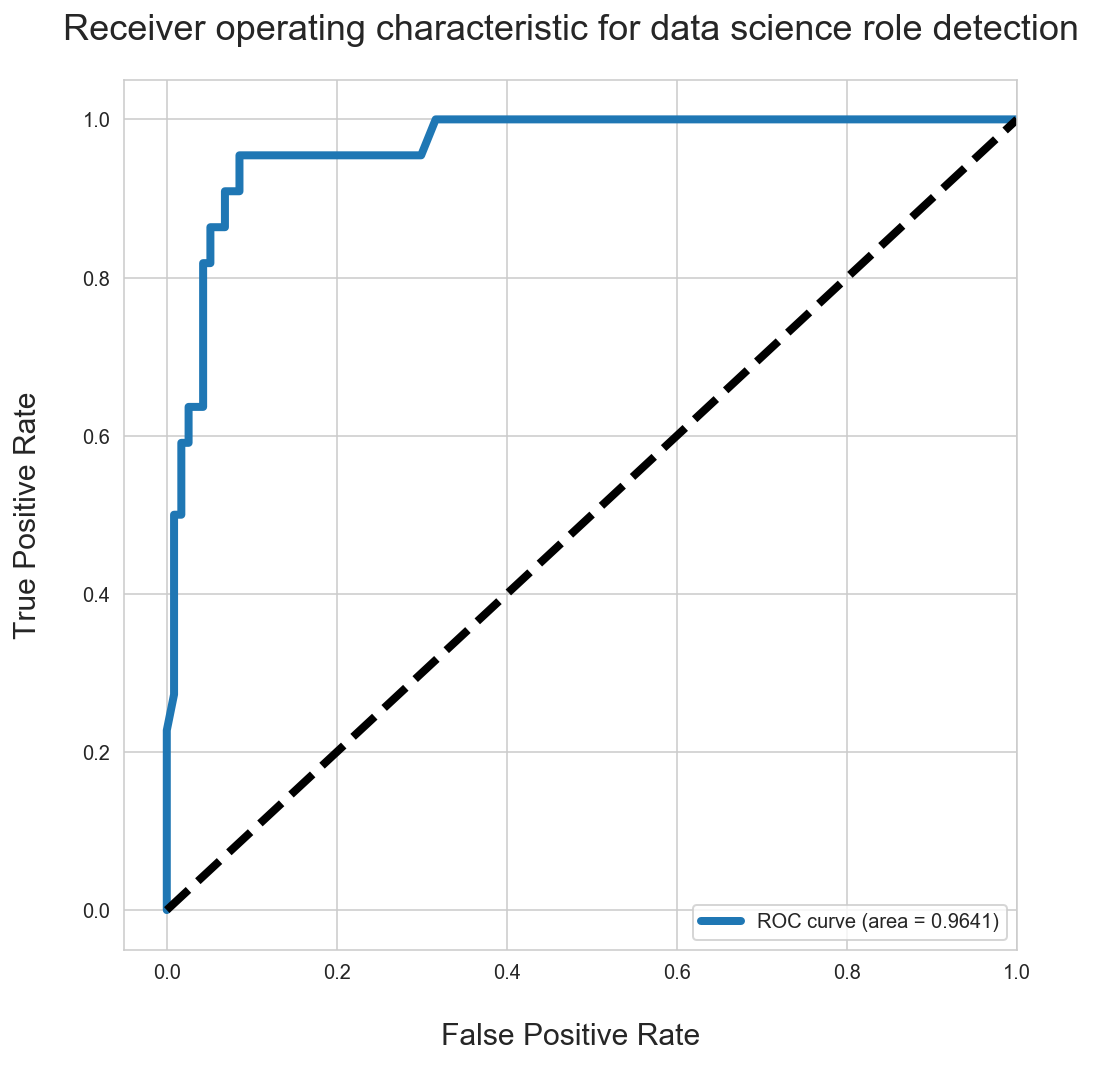

In [18]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15, labelpad=20)
plt.ylabel('True Positive Rate', fontsize=15, labelpad=20)
plt.title('Receiver operating characteristic for data science role detection', fontsize=18, pad=20)
plt.legend(loc="lower right")
plt.show()

In [19]:
# Checking feature importances
df_impt = pd.DataFrame(ranfbest.feature_importances_, index=X_train.columns)
df_impt.rename(columns={0:'Feature Importance'},inplace=True)
df_impt.sort_values(by=['Feature Importance'], ascending=False, inplace=True)
df_impt.head(10)

,Feature Importance
machine,0.029673
science,0.021483
scientist,0.021360
learning,0.019110
algorithms,0.014047
mining,0.013689
models,0.012923
statistics,0.011505
python,0.010660
feature,0.008375


In [20]:
# Trying bag of words to classify with English stop words and ngrams (2,2)
cvec = CountVectorizer(strip_accents = 'ascii', stop_words='english', ngram_range=(2,2))
Xcv = cvec.fit_transform(X)
print(Xcv.shape)
Xcv = pd.DataFrame(Xcv.todense(), columns=cvec.get_feature_names())

(694, 69188)


In [21]:
# Applying train-test split with stratify to ensure that the proportion of y is kept

X_train, X_test, y_train, y_test = train_test_split(Xcv, y, test_size=0.2, random_state=42, stratify=y)

# Checking baseline accuracy
baseline = 1 - np.mean(y_train)
print("Baseline:", baseline)

Baseline: 0.8378378378378378


In [22]:
# Applying Random Forest Classifier using GridSearchCV to find optimum parameters

ranf_parameters = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [None,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, verbose=1, cv=5)
ranf_result = ranf_gridsearcher.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 22.9min finished


In [23]:
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(X_test, y_test))
print('Baseline:', baseline)
confusion_matrix(y_test, ranfbest.predict(X_test))

Best mean cross-validated score achieved: 0.8990990990990991
Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Random Forest Classification score: 0.8848920863309353
Baseline: 0.8378378378378378


array([[116,   1],
       [ 15,   7]])

In [24]:
print(classification_report(y_test, ranfbest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       117
           1       0.88      0.32      0.47        22

   micro avg       0.88      0.88      0.88       139
   macro avg       0.88      0.65      0.70       139
weighted avg       0.88      0.88      0.86       139



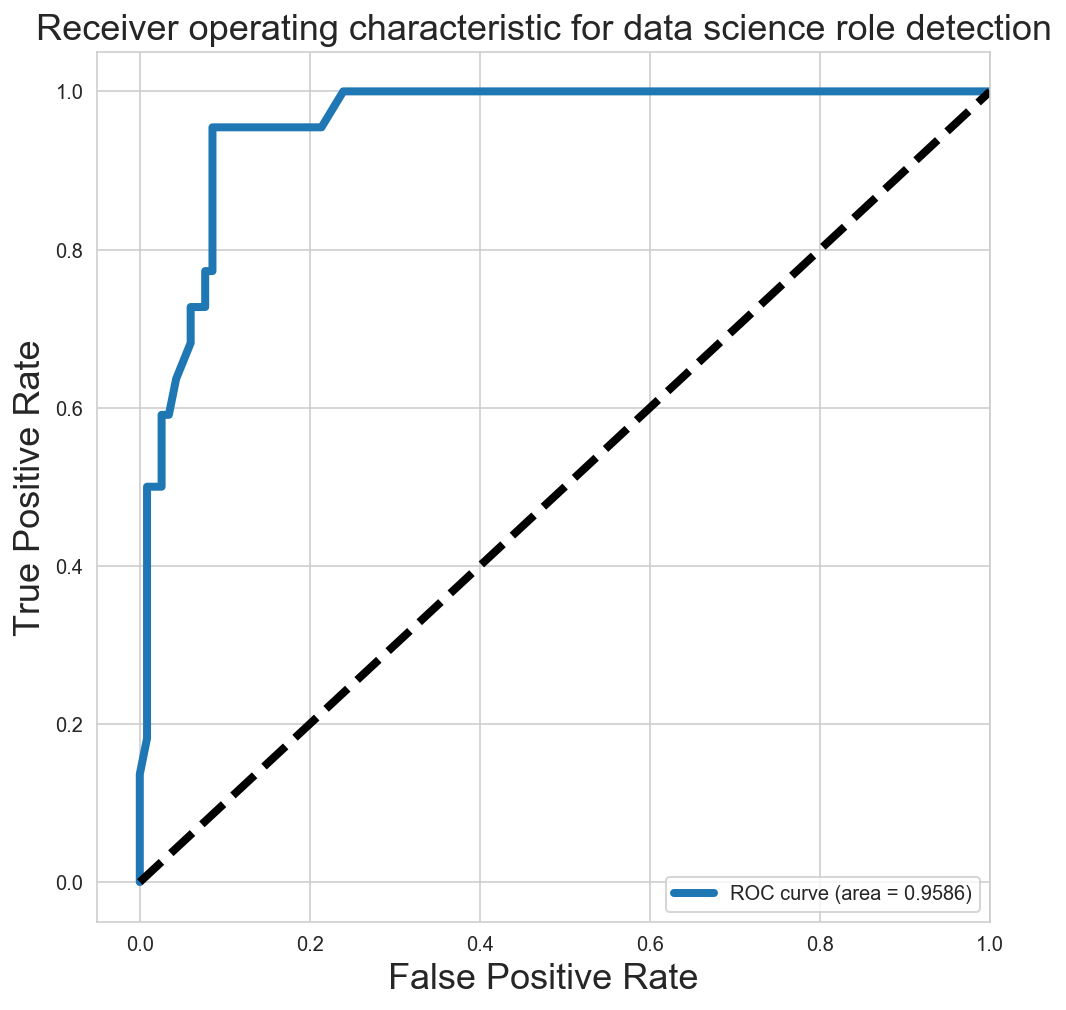

In [25]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for data science role detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [26]:
# Checking feature importances
df_impt = pd.DataFrame(ranfbest.feature_importances_, index=X_train.columns)
df_impt.rename(columns={0:'Feature Importance'},inplace=True)
df_impt.sort_values(by=['Feature Importance'], ascending=False, inplace=True)
df_impt.head(10)

,Feature Importance
machine learning,0.021591
data scientist,0.018291
data science,0.014330
data mining,0.005885
predictive models,0.004465
experience proven,0.004255
learning algorithms,0.004112
understanding machine,0.004059
operations research,0.003880
deep learning,0.003672


In [27]:
# Applying Naive Bayes
mnb = naive_bayes.MultinomialNB()
bnb = naive_bayes.BernoulliNB()

In [28]:
# Using Multinomial Naive Bayes
mnb.fit(X_train, y_train)
mnb_scores = cross_val_score(mnb, X_train, y_train, cv=5)

print("Cross-validated scores:", mnb_scores)
print("Mean Cross-validated scores:", np.mean(mnb_scores))
print("Baseline:", baseline)

Cross-validated scores: [0.68468468 0.63963964 0.67567568 0.72072072 0.64864865]
Mean Cross-validated scores: 0.6738738738738739
Baseline: 0.8378378378378378


In [29]:
confusion_matrix(y_test, mnb.predict(X_test))

array([[59, 58],
       [ 2, 20]])

In [30]:
print(classification_report(y_test, mnb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.50      0.66       117
           1       0.26      0.91      0.40        22

   micro avg       0.57      0.57      0.57       139
   macro avg       0.61      0.71      0.53       139
weighted avg       0.85      0.57      0.62       139



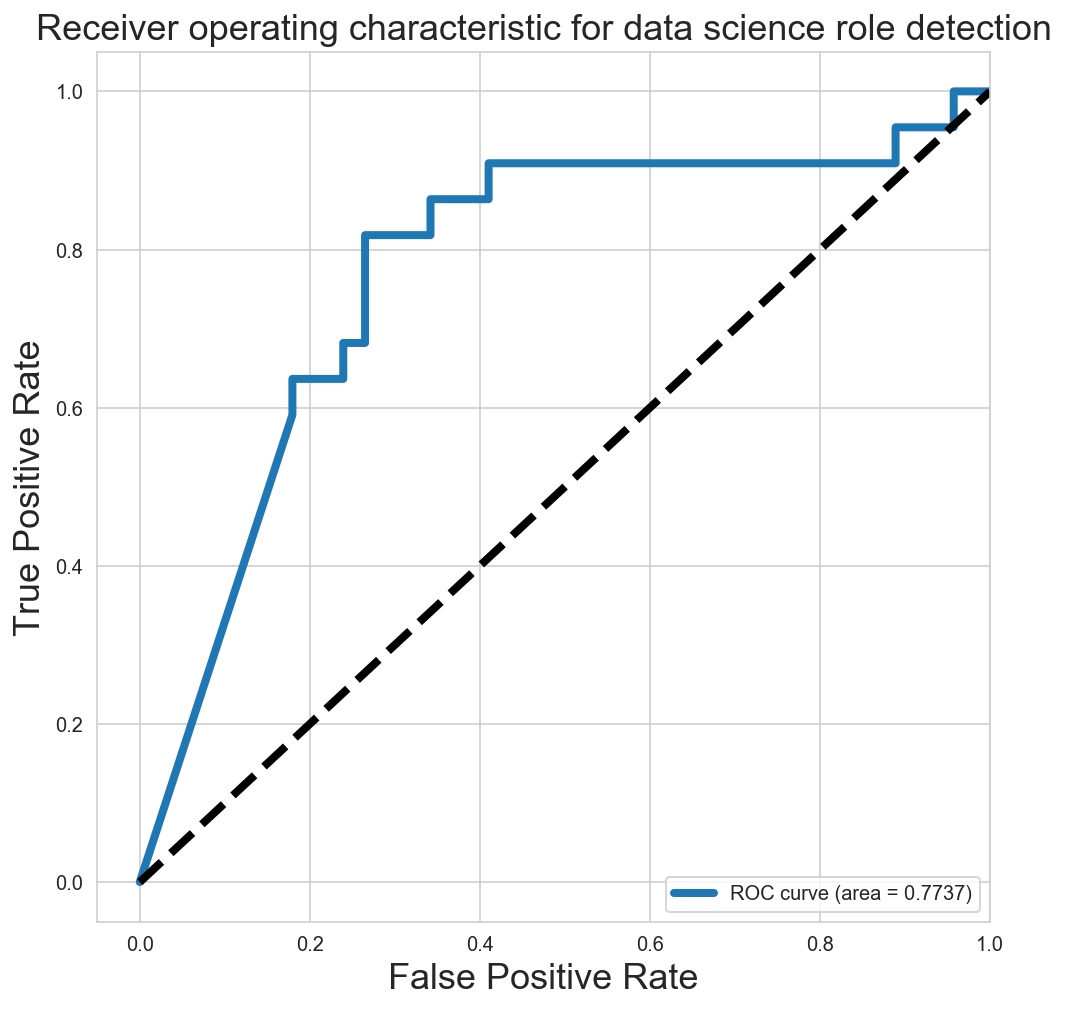

In [31]:
fpr, tpr, _ = roc_curve(y_test, mnb.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for data science role detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [32]:
# Using Bernoulli Naive Bayes
bnb.fit(X_train, y_train)
bnb_scores = cross_val_score(bnb, X_train, y_train, cv=5)

print("Cross-validated scores:", bnb_scores)
print("Mean Cross-validated scores:", np.mean(bnb_scores))
print("Baseline:", baseline)

Cross-validated scores: [0.83783784 0.84684685 0.83783784 0.83783784 0.84684685]
Mean Cross-validated scores: 0.8414414414414415
Baseline: 0.8378378378378378


In [33]:
confusion_matrix(y_test, bnb.predict(X_test))

array([[114,   3],
       [ 21,   1]])

In [34]:
print(classification_report(y_test, bnb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       117
           1       0.25      0.05      0.08        22

   micro avg       0.83      0.83      0.83       139
   macro avg       0.55      0.51      0.49       139
weighted avg       0.75      0.83      0.77       139



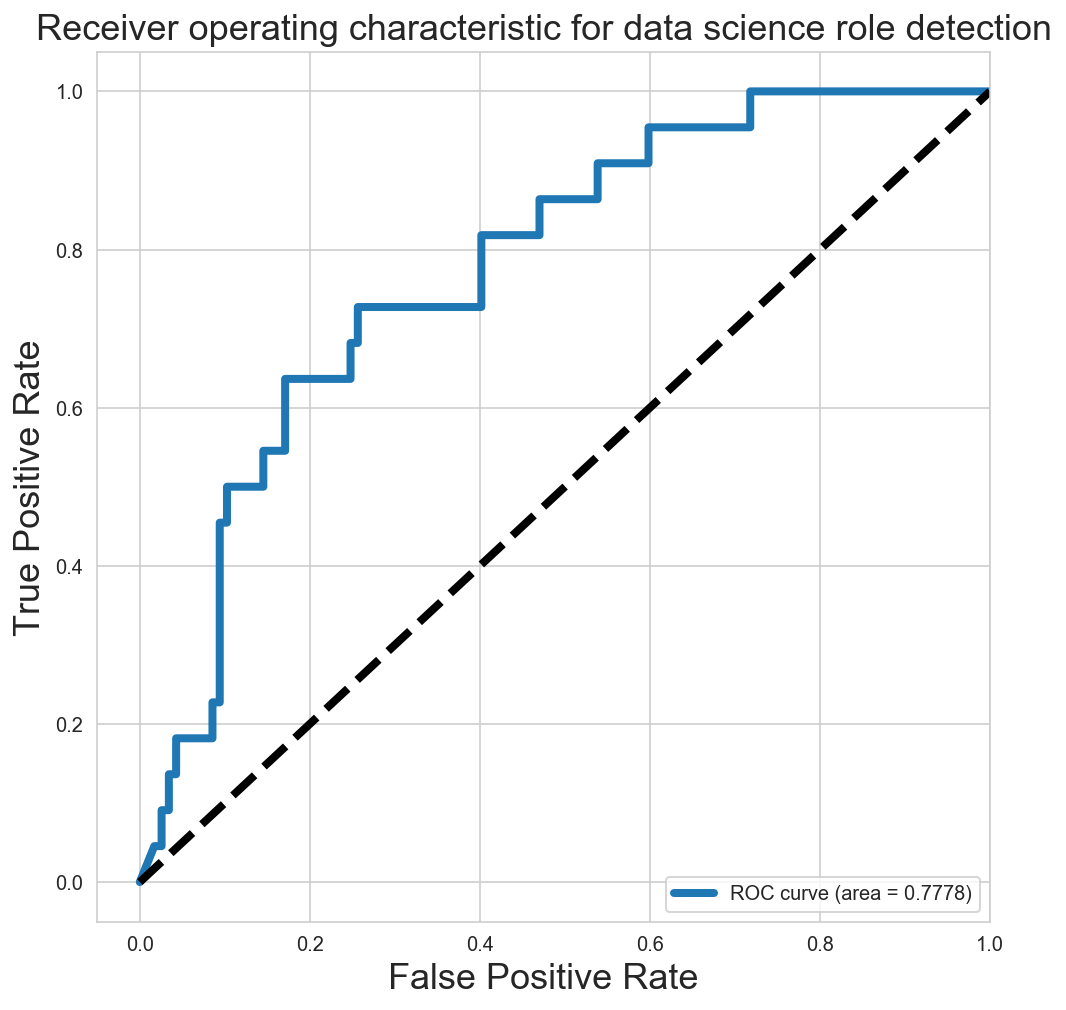

In [35]:
fpr, tpr, _ = roc_curve(y_test, bnb.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for data science role detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [36]:
# Applying Logistic Regression

logc = LogisticRegression(penalty = 'l2',C = 2,random_state = 42, solver='liblinear')
logc.fit(X_train, y_train)

logc_scores = cross_val_score(logc, X_train, y_train, cv=5)

print("Cross-validated scores:", logc_scores)
print("Mean Cross-validated scores:", np.mean(logc_scores))
print("Baseline:", baseline)

confusion_matrix(y_test, logc.predict(X_test))

Cross-validated scores: [0.92792793 0.95495495 0.94594595 0.97297297 0.93693694]
Mean Cross-validated scores: 0.9477477477477478
Baseline: 0.8378378378378378


array([[113,   4],
       [  9,  13]])

In [37]:
print(classification_report(y_test, logc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       117
           1       0.76      0.59      0.67        22

   micro avg       0.91      0.91      0.91       139
   macro avg       0.85      0.78      0.81       139
weighted avg       0.90      0.91      0.90       139



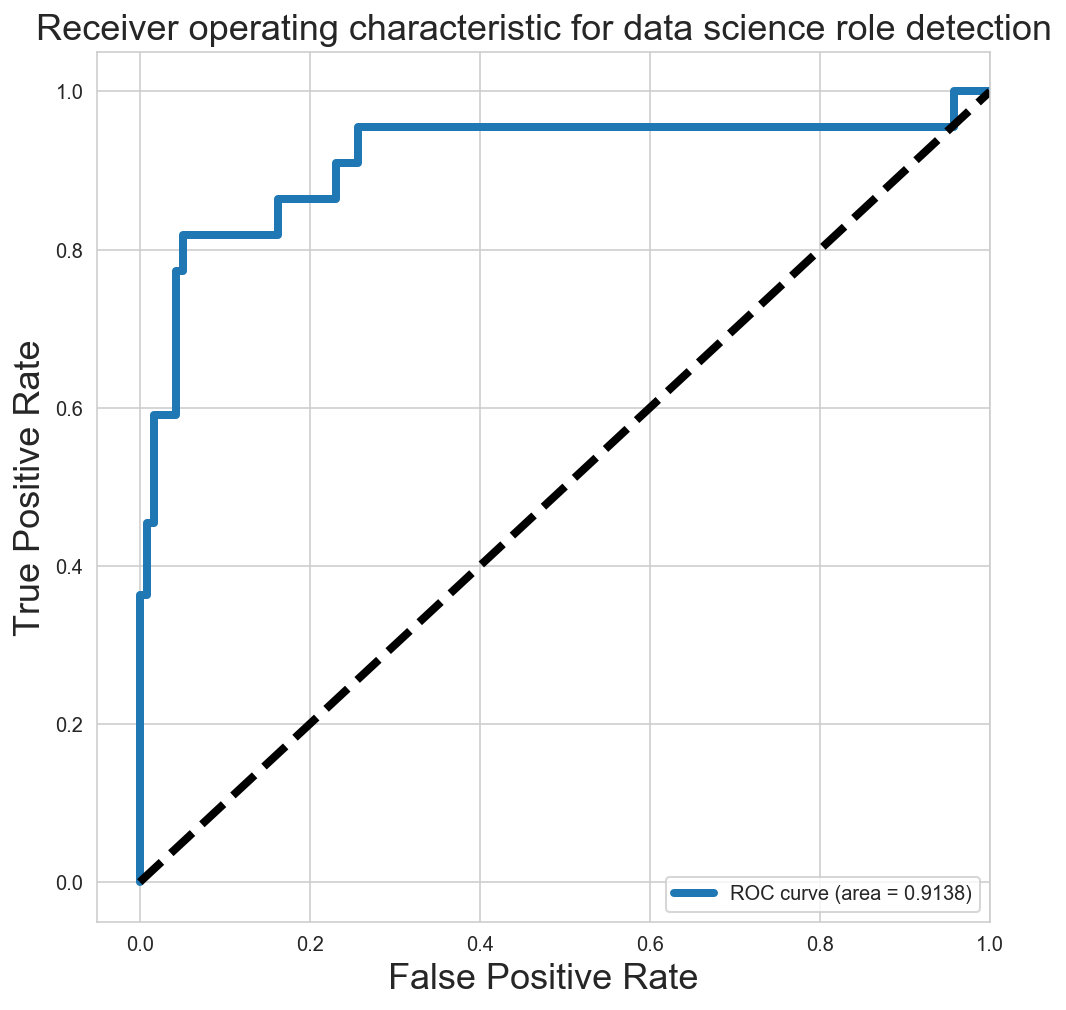

In [38]:
fpr, tpr, _ = roc_curve(y_test, logc.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for data science role detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [39]:
# Checking feature importances via coefficients
df_coef = pd.DataFrame(logc.coef_[0], index=X_train.columns)
df_coef.rename(columns={0:'Coefficient'},inplace=True)
df_coef['Magnitude'] = np.abs(df_coef['Coefficient'])
df_coef.sort_values(by=['Magnitude'], ascending=False, inplace=True)
df_coef.head(10)

,Coefficient,Magnitude
data scientist,1.022787,1.022787
data science,0.957845,0.957845
machine learning,0.807797,0.807797
data engineer,-0.712791,0.712791
years experience,-0.555208,0.555208
scientist engineer,0.483654,0.483654
data mining,0.463240,0.463240
business analyst,-0.458900,0.458900
communication skills,-0.395085,0.395085
data analytics,-0.372308,0.372308


In [40]:
# Applying Logistic Regression with class weights using GridSearchCV to find optimum parameters

logrw_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25),
    'class_weight': ['balanced']
}

logrw_gridsearcher = GridSearchCV(LogisticRegression(), logrw_parameters, verbose=1)
logrw_result = logrw_gridsearcher.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.3min finished


In [41]:
print('Best mean cross-validated score achieved:', logrw_result.best_score_)
print('Best parameters:', logrw_result.best_params_)
logrwbest = logrw_result.best_estimator_
print('Logistic Regression Classification score:', logrwbest.score(X_test, y_test))
print('Baseline:', baseline)

confusion_matrix(y_test, logc.predict(X_test))

Best mean cross-validated score achieved: 0.9621621621621622
Best parameters: {'C': 11.0, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification score: 0.9280575539568345
Baseline: 0.8378378378378378


array([[113,   4],
       [  9,  13]])

In [42]:
print(classification_report(y_test, logrwbest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       117
           1       0.77      0.77      0.77        22

   micro avg       0.93      0.93      0.93       139
   macro avg       0.86      0.86      0.86       139
weighted avg       0.93      0.93      0.93       139



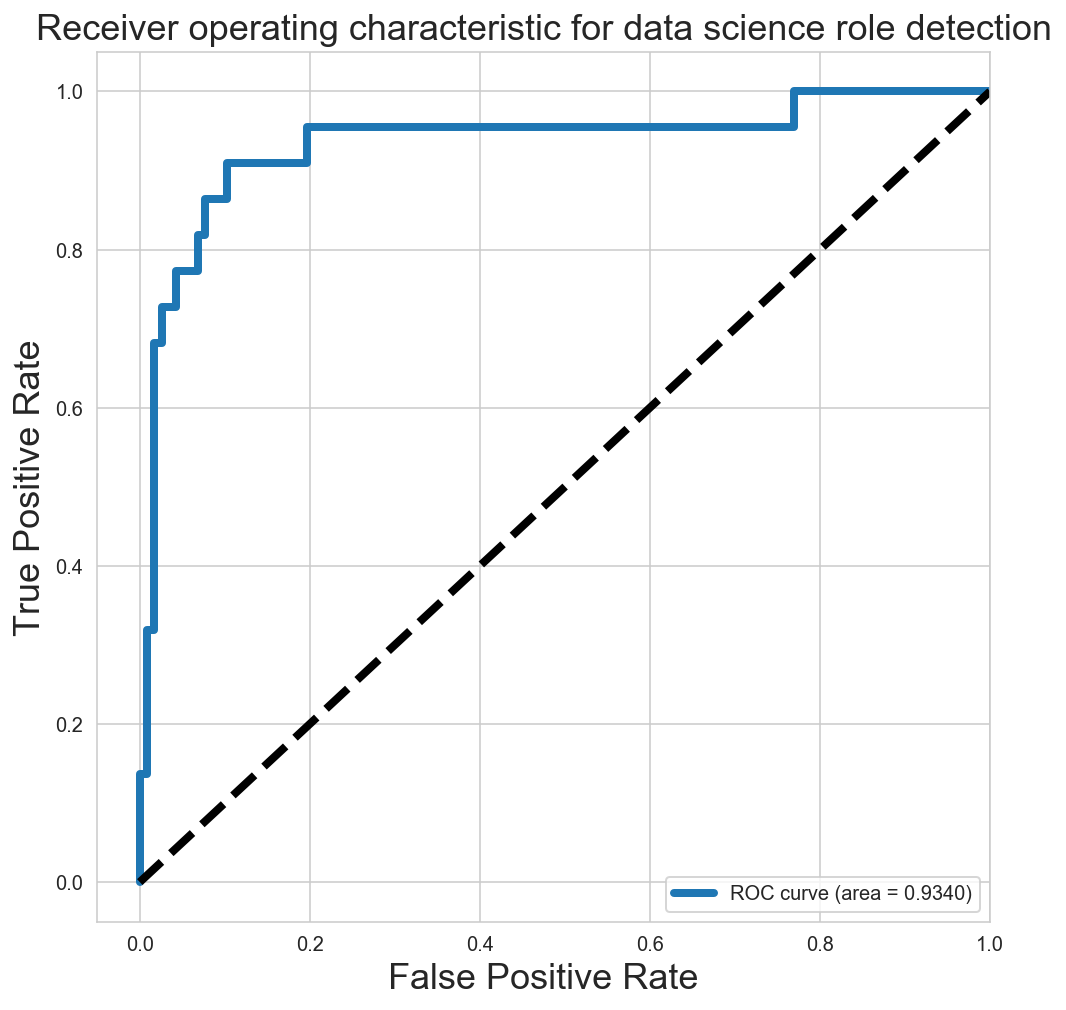

In [43]:
fpr, tpr, _ = roc_curve(y_test, logrwbest.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for data science role detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [44]:
# Checking feature importances via coefficients
df_coef = pd.DataFrame(logrwbest.coef_[0], index=X_train.columns)
df_coef.rename(columns={0:'Coefficient'},inplace=True)
df_coef['Magnitude'] = np.abs(df_coef['Coefficient'])
df_coef.sort_values(by=['Magnitude'], ascending=False, inplace=True)
df_coef.head(10)

,Coefficient,Magnitude
data scientist,6.219087,6.219087
data engineer,-4.736280,4.736280
use machine,3.557904,3.557904
experience statistical,3.262611,3.262611
analysis using,2.761625,2.761625
data science,2.490242,2.490242
ai ml,1.906522,1.906522
industry partners,1.893057,1.893057
learning models,-1.773190,1.773190
anomaly detection,1.758785,1.758785


In [45]:
# Trying TF-IDF vectorizer with max_df=0.9 and ngrams (2,2)
tfidf = TfidfVectorizer(max_df=0.9, ngram_range=(2,2))

Xtf = tfidf.fit_transform(X)
print(Xtf.shape)
Xtf = pd.DataFrame(Xtf.todense(), columns=tfidf.get_feature_names())

(694, 71529)


In [46]:
# Applying train-test split with stratify to ensure that the proportion of y is kept

X_train, X_test, y_train, y_test = train_test_split(Xtf, y, test_size=0.2, random_state=42, stratify=y)

# Checking baseline accuracy
baseline = 1 - np.mean(y_train)
print("Baseline:", baseline)

Baseline: 0.8378378378378378


In [47]:
# Applying Random Forest Classifier using GridSearchCV to find optimum parameters
# Reducing to just searching for n_estimators due to the number of features

ranf_parameters = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto'],
    'max_depth' : [None],
    'criterion' :['gini']
}

ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, verbose=1, cv=5)
ranf_result = ranf_gridsearcher.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.9min finished


In [48]:
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(X_test, y_test))
print('Baseline:', baseline)
confusion_matrix(y_test, ranfbest.predict(X_test))

Best mean cross-validated score achieved: 0.8972972972972973
Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}
Random Forest Classification score: 0.8776978417266187
Baseline: 0.8378378378378378


array([[116,   1],
       [ 16,   6]])

In [49]:
print(classification_report(y_test, ranfbest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       117
           1       0.86      0.27      0.41        22

   micro avg       0.88      0.88      0.88       139
   macro avg       0.87      0.63      0.67       139
weighted avg       0.88      0.88      0.85       139



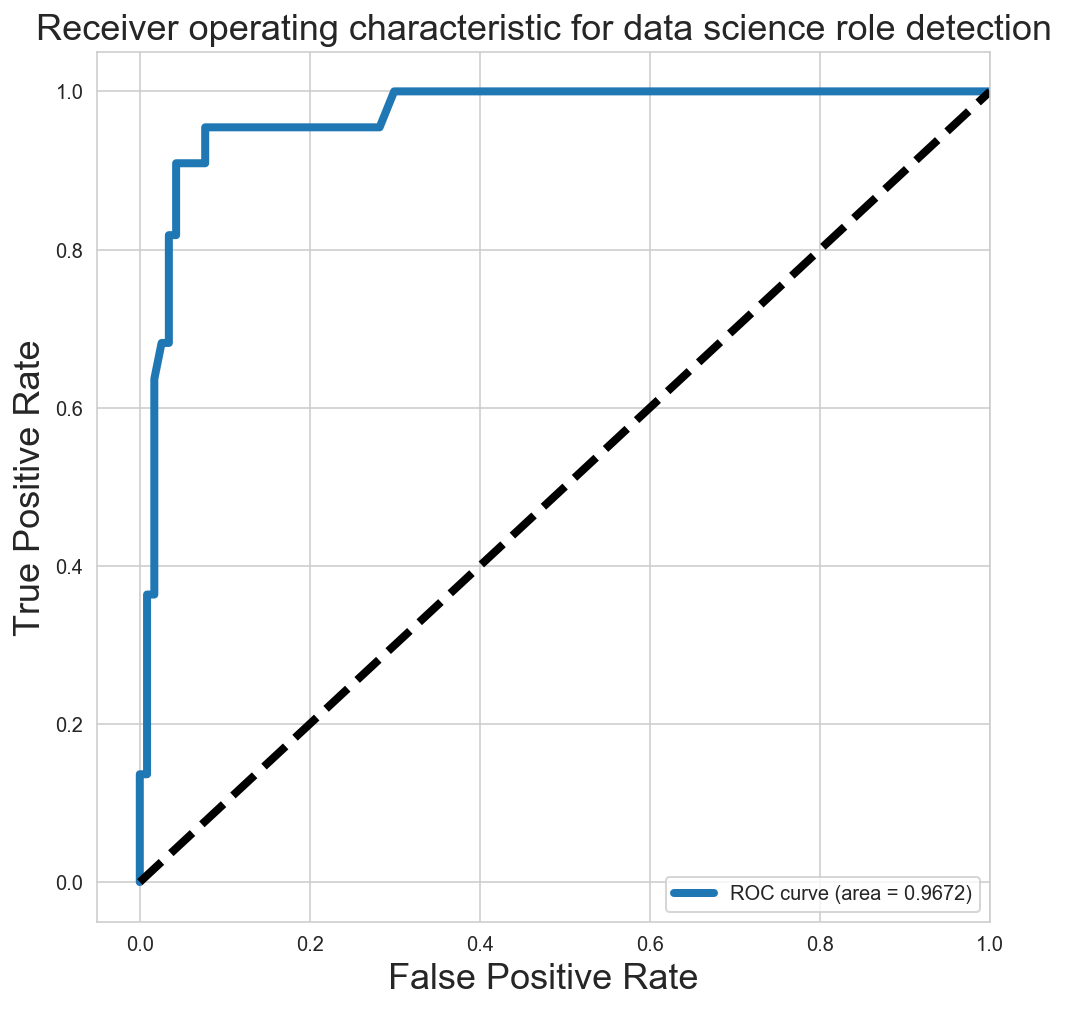

In [50]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for data science role detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [51]:
# Checking feature importances
df_impt = pd.DataFrame(ranfbest.feature_importances_, index=X_train.columns)
df_impt.rename(columns={0:'Feature Importance'},inplace=True)
df_impt.sort_values(by=['Feature Importance'], ascending=False, inplace=True)
df_impt.head(10)

,Feature Importance
machine learning,0.013024
data science,0.008672
data scientist,0.007656
and machine,0.006933
deep learning,0.006740
learning techniques,0.005606
data mining,0.005545
learning and,0.005405
operations research,0.004352
learning algorithms,0.004086


In [52]:
# Applying Logistic Regression

logc = LogisticRegression(penalty = 'l2',C = 2,random_state = 42, solver='liblinear')
logc.fit(X_train, y_train)

logc_scores = cross_val_score(logc, X_train, y_train, cv=5)

print("Cross-validated scores:", logc_scores)
print("Mean Cross-validated scores:", np.mean(logc_scores))
print("Baseline:", baseline)

confusion_matrix(y_test, logc.predict(X_test))

Cross-validated scores: [0.84684685 0.88288288 0.84684685 0.9009009  0.86486486]
Mean Cross-validated scores: 0.8684684684684687
Baseline: 0.8378378378378378


array([[116,   1],
       [ 18,   4]])

In [53]:
print(classification_report(y_test, logc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       117
           1       0.80      0.18      0.30        22

   micro avg       0.86      0.86      0.86       139
   macro avg       0.83      0.59      0.61       139
weighted avg       0.86      0.86      0.82       139



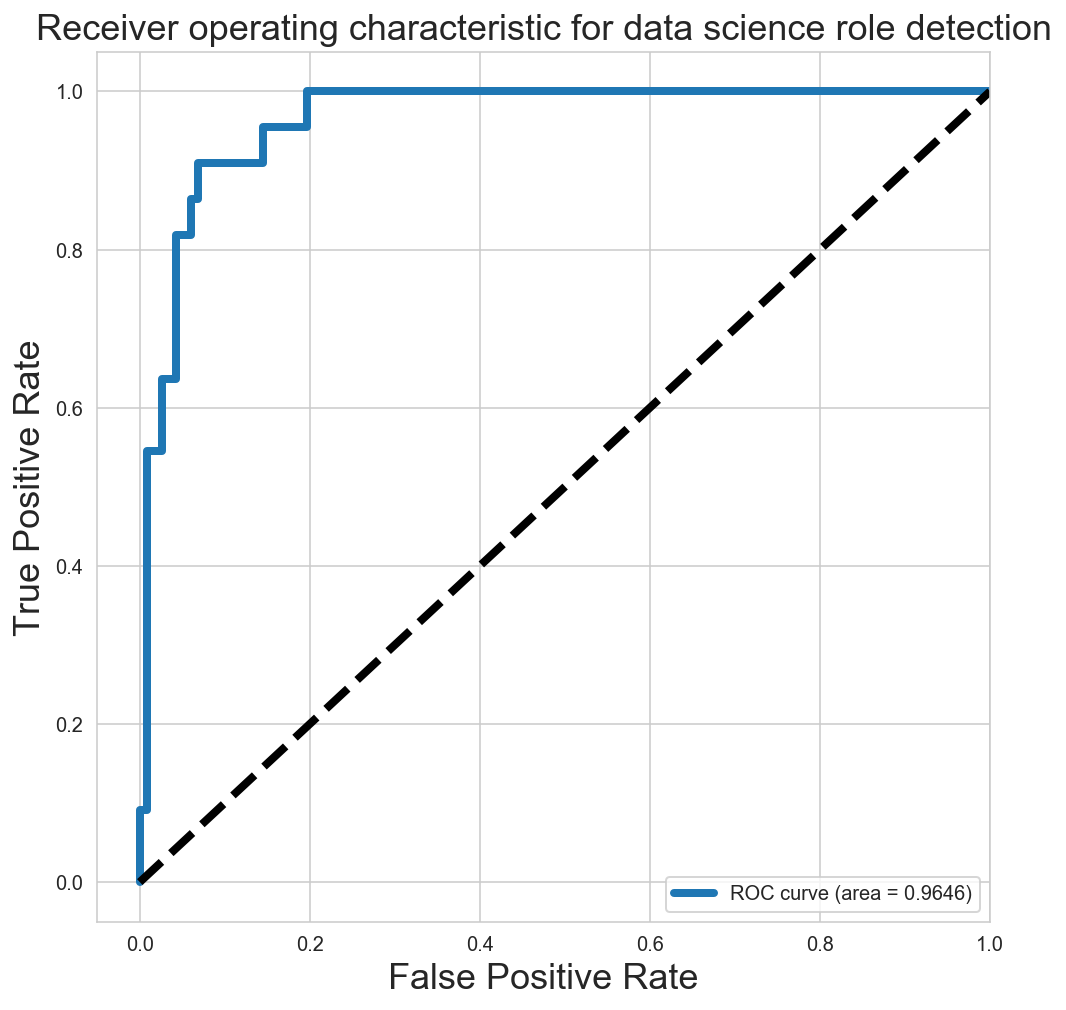

In [54]:
fpr, tpr, _ = roc_curve(y_test, logc.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for data science role detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [55]:
# Checking feature importances via coefficients
df_coef = pd.DataFrame(logc.coef_[0], index=X_train.columns)
df_coef.rename(columns={0:'Coefficient'},inplace=True)
df_coef['Magnitude'] = np.abs(df_coef['Coefficient'])
df_coef.sort_values(by=['Magnitude'], ascending=False, inplace=True)
df_coef.head(10)

,Coefficient,Magnitude
machine learning,3.682794,3.682794
data science,3.220011,3.220011
data scientist,1.535842,1.535842
deep learning,1.447643,1.447643
data mining,1.326332,1.326332
and machine,1.102667,1.102667
learning and,1.076664,1.076664
ai ml,0.872254,0.872254
ml aa,0.848647,0.848647
learning algorithms,0.845014,0.845014


In [56]:
# Applying Logistic Regression with class weights

logc = LogisticRegression(penalty = 'l2',C = 2,random_state = 42, solver='liblinear', class_weight='balanced')
logc.fit(X_train, y_train)

logc_scores = cross_val_score(logc, X_train, y_train, cv=5)

print("Cross-validated scores:", logc_scores)
print("Mean Cross-validated scores:", np.mean(logc_scores))
print("Baseline:", baseline)

confusion_matrix(y_test, logc.predict(X_test))

Cross-validated scores: [0.90990991 0.95495495 0.9009009  0.93693694 0.90990991]
Mean Cross-validated scores: 0.9225225225225225
Baseline: 0.8378378378378378


array([[115,   2],
       [ 10,  12]])

In [57]:
print(classification_report(y_test, logc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       117
           1       0.86      0.55      0.67        22

   micro avg       0.91      0.91      0.91       139
   macro avg       0.89      0.76      0.81       139
weighted avg       0.91      0.91      0.91       139



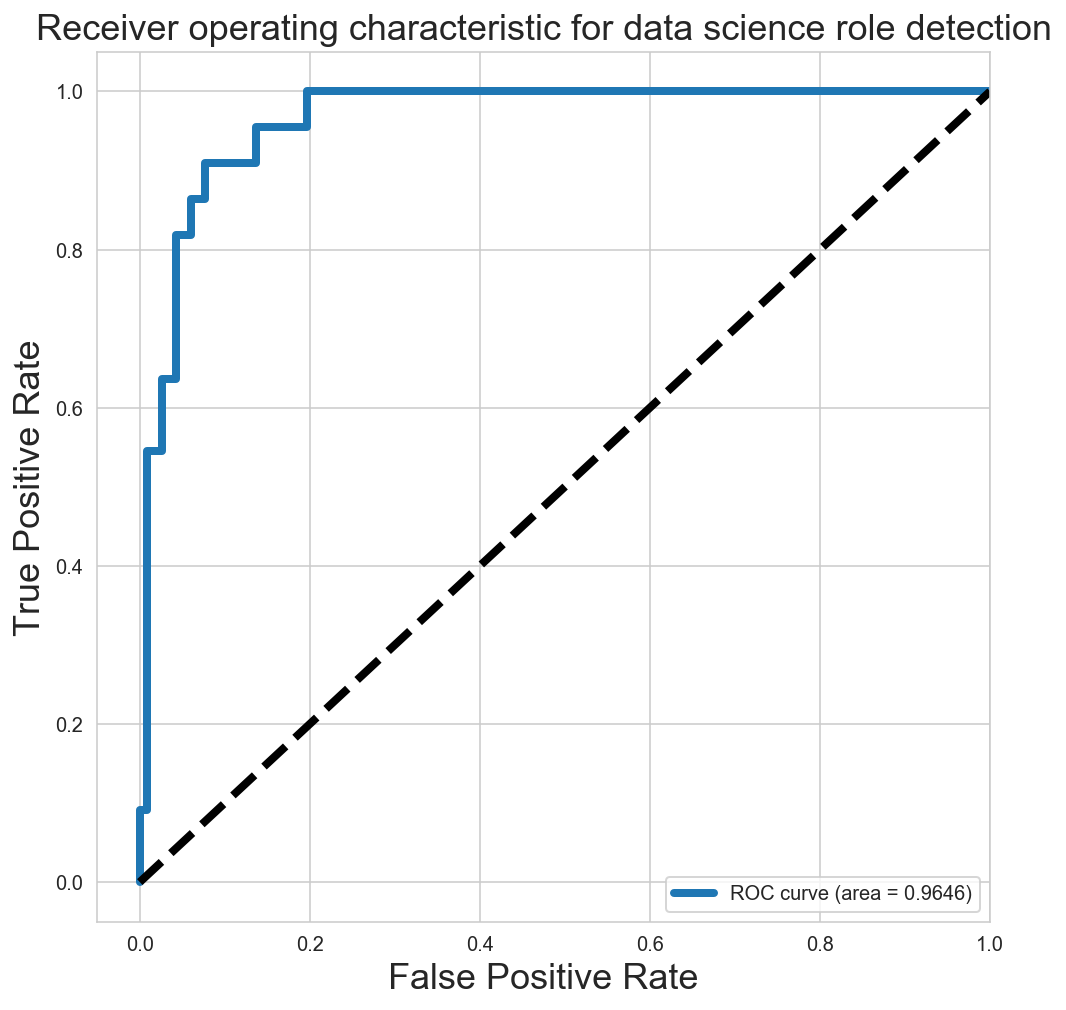

In [58]:
fpr, tpr, _ = roc_curve(y_test, logc.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for data science role detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [59]:
# Checking feature importances via coefficients
df_coef = pd.DataFrame(logc.coef_[0], index=X_train.columns)
df_coef.rename(columns={0:'Coefficient'},inplace=True)
df_coef['Magnitude'] = np.abs(df_coef['Coefficient'])
df_coef.sort_values(by=['Magnitude'], ascending=False, inplace=True)
df_coef.head(10)

,Coefficient,Magnitude
machine learning,4.416660,4.416660
data science,3.940064,3.940064
data scientist,1.868073,1.868073
deep learning,1.707757,1.707757
data mining,1.595131,1.595131
and machine,1.282284,1.282284
learning and,1.251819,1.251819
ai ml,1.030065,1.030065
models and,1.013581,1.013581
learning algorithms,1.010856,1.010856


<div class="alert alert-warning">
    
## Executive Summary

Classifiying a data science job vs other data related roles.

We re-used the job postings scraped for part 1, but we started the cleaning process all over again as we were more focused on the job titles as compared to the salary. As we framed the question in terms of distinguishing data science jobs from other data related roles, there was a significant reduction in terms of the amount of data we used for this classification problem. 

### Approach

The job titles that we kept had to be include data or analyst in them for it to be considered. Job titles that had data science or data scientist were classified as data science job roles. Out of the job titles that were considered for classification, only 16.2% were data science job roles which means there is a slight class imbalance.

We attempted various classification techniques (Random Forest Classification, Naive Bayes and Logistic Regression) based on the job description and requirements of the role. Similar to part 1, we also attempted to use both CountVectorizer as well as TF-IDF vectorizer on the text to see if there are is any improvements to the results.

The best model was Random Forest Classifier using TF-IDF vectorizer with max_df=0.9 and ngrams (2,2). The AUC of the model is 0.9672. Based on this model we had:

                precision    recall  f1-score   support

           0       0.88      0.99      0.93       117
           1       0.86      0.27      0.41        22
           
           1: Data science roles      0: Other data related roles

The words with highest importance are "machine learning", "data science" and "data scientist".

### Limitations

Due to the class imbalance of the data, there might have been some issue of the majority class overwhelming the minority class. Also, as we are dealing with text data, we are unable to easily implement resampling techniques from the imblearn library. Perhaps it might be possible to manually resample the data to obtain better results. We could have also tried other techniques such as stacking to see if we were able to get better results.
    
</div>